## Gaussian Process Regression wit GPy

In [294]:
import pandas as pd

### 1. Read the data

In [295]:
all_positions = pd.read_csv('../test-data/positions_xyz_2024-02-27_11h29m.csv', delimiter=',')
all_positions

,x,y,z
0,7.140000,3.070000,15.00000
1,10.140000,3.070000,15.00000
2,10.140000,3.070000,15.00000
3,10.140000,3.070000,15.00000
4,10.138330,3.169981,15.09998
...,...,...,...
500,5.179743,0.799010,12.72901
501,5.256516,0.734943,12.66494
502,5.335387,0.673466,12.60347
503,5.416258,0.614656,12.54466


In [296]:
all_red_ball_positions = pd.read_csv('../test-data/red_ball_coordinates_128px_2024-02-27_11h29m.csv', delimiter=',')

all_red_ball_positions

,u0,v0,u1,v1,u2,v2,u3,v3,u4,v4,u5,v5,u6,v6
0,0.0,42.0,87.0,39.0,NaN,NaN,44.0,83.0,89.0,83.0,NaN,NaN,69.0,122.0
1,0.5,42.5,87.0,40.0,NaN,NaN,45.0,84.0,89.0,84.0,NaN,NaN,68.5,120.5
2,0.5,43.5,87.0,41.0,NaN,NaN,45.0,85.0,89.0,85.0,NaN,NaN,68.5,120.5
3,1.0,45.0,87.5,42.0,NaN,NaN,45.0,86.0,89.0,86.0,NaN,NaN,68.5,120.5
4,1.0,45.5,88.0,43.0,NaN,NaN,45.0,86.0,90.0,87.0,NaN,NaN,68.5,120.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
496,68.0,10.0,55.0,26.0,64.0,59.0,111.0,59.0,59.5,69.0,54.5,105.0,68.0,118.5
497,67.0,9.0,55.0,26.0,63.0,58.0,110.0,58.0,59.5,69.0,54.0,103.0,68.0,118.5
498,66.0,8.0,55.0,26.0,62.0,57.0,109.0,57.0,59.5,69.0,53.0,102.5,68.0,118.5
499,65.0,5.0,55.0,26.0,61.0,55.0,107.5,55.0,59.5,69.0,52.0,101.0,68.0,118.5


In [297]:
all_positions = all_positions.iloc[4:]
all_positions.reset_index(drop=True, inplace=True)
all_red_ball_positions.shape,  all_positions.shape

((501, 14), (501, 3))

In [298]:
# Assuming all_red_ball_positions and all_positions are your DataFrames
combined_data = pd.concat([all_red_ball_positions, all_positions], axis=1)

# Remove all rows with 6 or more missing values not with thresh
#combined_data = combined_data.dropna(thresh=combined_data.shape[1]-7)
combined_data

,u0,v0,u1,v1,u2,v2,u3,v3,u4,v4,u5,v5,u6,v6,x,y,z
0,0.0,42.0,87.0,39.0,NaN,NaN,44.0,83.0,89.0,83.0,NaN,NaN,69.0,122.0,10.138330,3.169981,15.09998
1,0.5,42.5,87.0,40.0,NaN,NaN,45.0,84.0,89.0,84.0,NaN,NaN,68.5,120.5,10.133340,3.269852,15.19985
2,0.5,43.5,87.0,41.0,NaN,NaN,45.0,85.0,89.0,85.0,NaN,NaN,68.5,120.5,10.125010,3.369500,15.29950
3,1.0,45.0,87.5,42.0,NaN,NaN,45.0,86.0,89.0,86.0,NaN,NaN,68.5,120.5,10.113370,3.468816,15.39882
4,1.0,45.5,88.0,43.0,NaN,NaN,45.0,86.0,90.0,87.0,NaN,NaN,68.5,120.5,10.098430,3.567688,15.49769
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
496,68.0,10.0,55.0,26.0,64.0,59.0,111.0,59.0,59.5,69.0,54.5,105.0,68.0,118.5,5.179743,0.799010,12.72901
497,67.0,9.0,55.0,26.0,63.0,58.0,110.0,58.0,59.5,69.0,54.0,103.0,68.0,118.5,5.256516,0.734943,12.66494
498,66.0,8.0,55.0,26.0,62.0,57.0,109.0,57.0,59.5,69.0,53.0,102.5,68.0,118.5,5.335387,0.673466,12.60347
499,65.0,5.0,55.0,26.0,61.0,55.0,107.5,55.0,59.5,69.0,52.0,101.0,68.0,118.5,5.416258,0.614656,12.54466


In [299]:
all_red_ball_positions = combined_data.iloc[:, :14]
all_positions = combined_data.iloc[:, 14:]
all_red_ball_positions.shape, all_positions.shape

((501, 14), (501, 3))

### 2. Handle Missing Values

In [300]:
from sklearn.impute import SimpleImputer, KNNImputer

imputer_mean = SimpleImputer(strategy='mean')
imputer_knn = KNNImputer(n_neighbors=2)
X_all = imputer_knn.fit_transform(all_red_ball_positions)
y_all = imputer_knn.fit_transform(all_positions)
X_all.shape, y_all.shape

((501, 14), (501, 3))

### 3. Prepare the Data

In [301]:
total_samples = len(X_all)
train_samples = int(0.8 * total_samples)

# Split the data
X_train = X_all[:train_samples]
y_train = y_all[:train_samples]

X_test = X_all[train_samples:]
y_test = y_all[train_samples:]

In [302]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((400, 14), (101, 14), (400, 3), (101, 3))

In [303]:
from sklearn.preprocessing import StandardScaler

scaler_x = StandardScaler()
scaler_y = StandardScaler()
X_scaled_train = scaler_x.fit_transform(X_train)
y_scaled_train = y_train

### 4. Train the Model

In [304]:
from GPy.kern import RBF
from GPy.models import GPRegression

#### 4.1 Train GP Regression Model with GPy for each output separately
For normal regression tasks

In [305]:
y_train_x = y_train[:, 0:1]
y_train_y = y_train[:, 1:2]
y_train_z = y_train[:, 2:3]

##### 4.1.1 Train GP Regression Model for X

In [306]:
kernel_x = RBF(input_dim=14)
model_x = GPRegression(X_scaled_train, y_train_x, kernel=kernel_x)
model_x.optimize(messages=True)

In [307]:
kernel_y = RBF(input_dim=14)
model_y = GPRegression(X_scaled_train, y_train_y, kernel=kernel_y)
model_y.optimize(messages=True)

In [308]:
kernel_z = RBF(input_dim=14)
model_z = GPRegression(X_scaled_train, y_train_z, kernel=kernel_z)
model_z.optimize(messages=True)

### 5. Make Predictions

In [309]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

X_scaled_test = scaler_x.transform(X_test)

#### 5.1 Predict with GP Regression Model

In [310]:
y_pred_reg_x, y_var_reg_x = model_x.predict(X_scaled_test)
y_pred_reg_y, y_var_reg_y = model_y.predict(X_scaled_test)
y_pred_reg_z, y_var_reg_z = model_z.predict(X_scaled_test)

### 6. Evaluate the Model

#### 6.1 Evaluate GP Regression Model

In [311]:
from utils.evaluate import evaluate_model

evaluate_model(y_test[:, 0], y_pred_reg_x, 'X Gaussian Process')

Mean Squared Error on X Gaussian Process Set: 0.00791852573479439
Mean Absolute Error on X Gaussian Process Set: 0.02202852423793633
R2 Score on X Gaussian Process set: 0.9968627289557104


(0.00791852573479439, 0.02202852423793633, 0.9968627289557104)

In [312]:
evaluate_model(y_test[:, 1], y_pred_reg_y, 'Y Gaussian Process')

Mean Squared Error on Y Gaussian Process Set: 0.001977336417009245
Mean Absolute Error on Y Gaussian Process Set: 0.018079438361081723
R2 Score on Y Gaussian Process set: 0.9994132547741484


(0.001977336417009245, 0.018079438361081723, 0.9994132547741484)

In [313]:
evaluate_model(y_test[:, 2], y_pred_reg_z, 'Z Gaussian Process')

Mean Squared Error on Z Gaussian Process Set: 0.0020510838339963962
Mean Absolute Error on Z Gaussian Process Set: 0.020480320272635653
R2 Score on Z Gaussian Process set: 0.9993913710398523


(0.0020510838339963962, 0.020480320272635653, 0.9993913710398523)

#### 6.2 Evaluate Sparse GP Regression Model

### 7. Visualize results

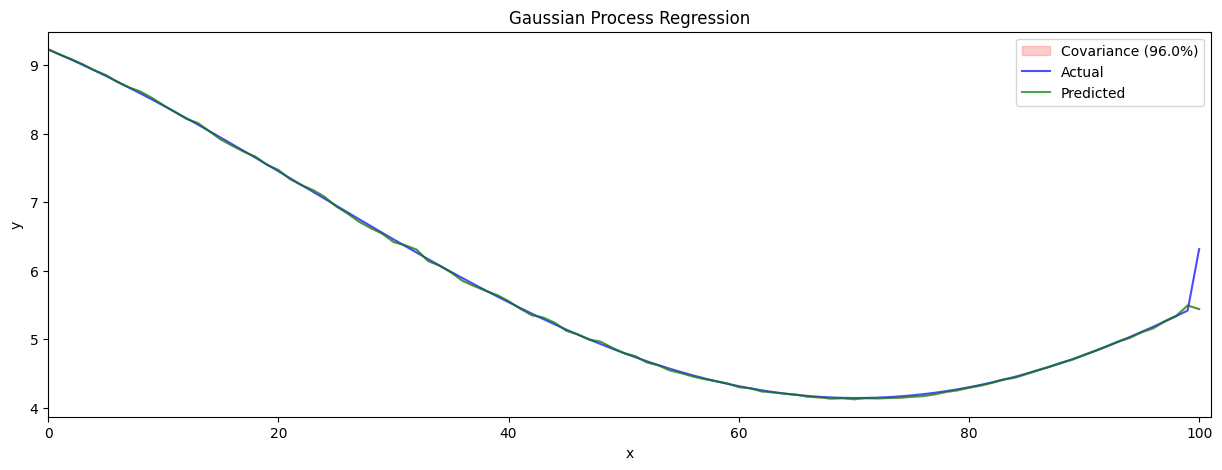

In [314]:
from utils.plot_maker_gaussian_process import gaussian_process_plot

gaussian_process_plot(y_test[:, 0], y_pred_reg_x[:, 0], y_var_reg_x[:, 0])


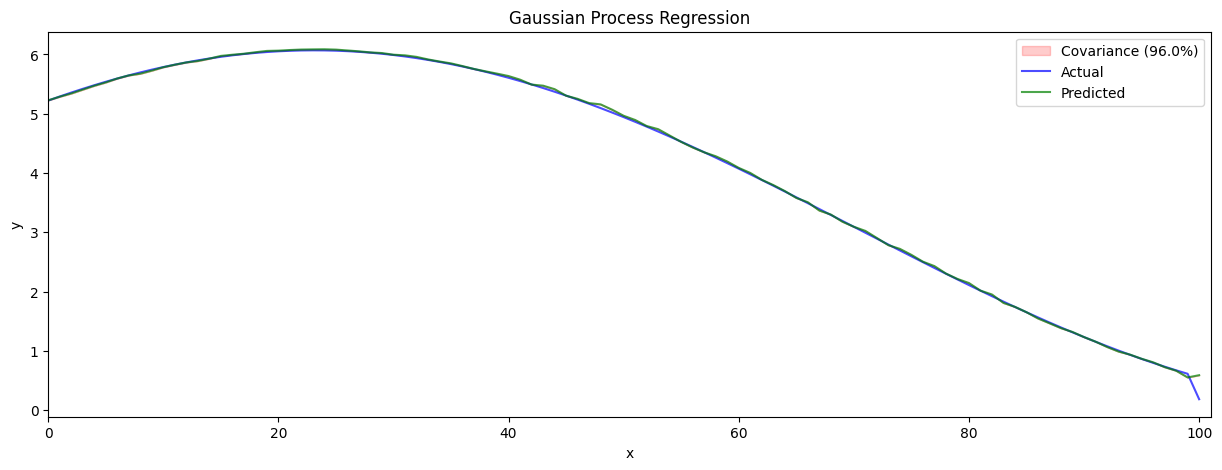

In [315]:
gaussian_process_plot(y_test[:, 1], y_pred_reg_y[:, 0], y_var_reg_y[:, 0])

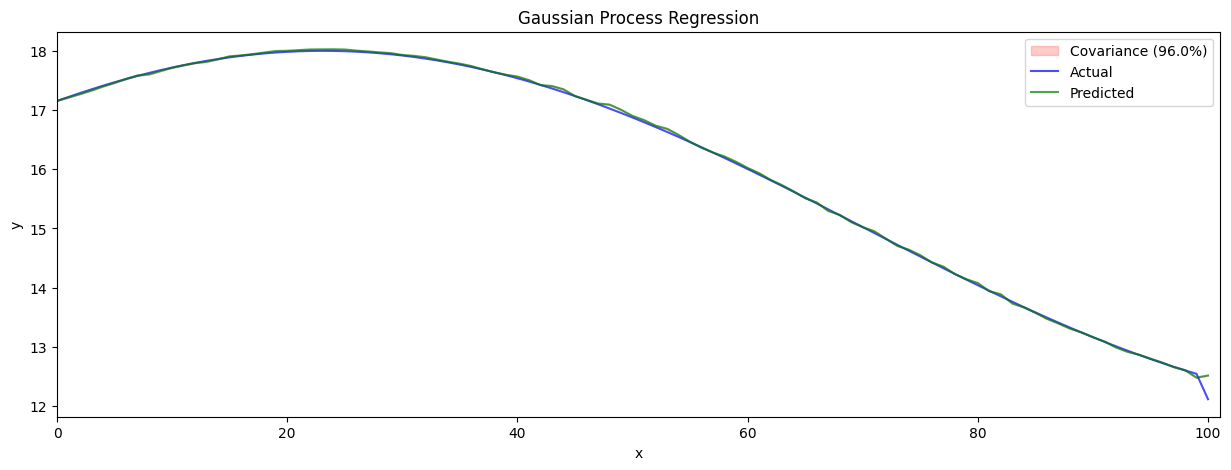

In [316]:
gaussian_process_plot(y_test[:, 2], y_pred_reg_z[:, 0], y_var_reg_z[:, 0])  